## Ablation Study
Appendix A in the paper

In [1]:
import os
wd = os.path.normpath(os.getcwd() + '/..')
os.chdir(wd)
os.getcwd()

'/home/hyunsung/Workspace/soccercpd'

In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
from joblib import Parallel, delayed
from scipy.spatial import distance_matrix
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
plt.rcParams['font.family'] = 'Arial'

In [3]:
%load_ext autoreload
%autoreload 2

from src.myconstants import *
from src.rolerep import RoleRep
from src.form_manager import FormManager

In [23]:
mode = 'noncpd'
activity_records = pd.read_csv('data/activity_records.csv', header=0, encoding='utf-8-sig')
form_periods = pd.read_pickle(f'data/{mode}/form_periods.pkl')
role_periods = pd.read_csv(f'data/{mode}/role_periods.csv', header=0, encoding='utf-8-sig')
role_records = pd.read_csv(f'data/{mode}/role_records.csv', header=0, encoding='utf-8-sig')
role_records.head()

,activity_id,player_period,form_period,role_period,session,start_dt,end_dt,duration,player_id,squad_num,player_name,base_role,x,y
0,12864,1,1,1,1,2020-01-01 14:00:00,2020-01-01 14:05:00,300.0,1235,23,P23,8,-983.0,-1609.0
1,12864,1,1,2,1,2020-01-01 14:05:00,2020-01-01 14:10:00,300.0,1235,23,P23,8,-983.0,-1609.0
2,12864,1,1,3,1,2020-01-01 14:10:00,2020-01-01 14:15:00,300.0,1235,23,P23,8,-983.0,-1609.0
3,12864,1,1,4,1,2020-01-01 14:15:00,2020-01-01 14:20:00,300.0,1235,23,P23,8,-983.0,-1609.0
4,12864,1,1,5,1,2020-01-01 14:20:00,2020-01-01 14:25:00,300.0,1235,23,P23,8,-983.0,-1609.0


### Formation Clustering

In [8]:
def compute_delaunay_dists(i, n):
    form1 = form_periods.iloc[i]
    dist_row = []
    for j in range(n):
        form2 = form_periods.iloc[j]
        cost_mat = distance_matrix(form1['coords'], form2['coords'])
        _, perm = linear_sum_assignment(cost_mat)
        edge_mat1 = form1['edge_mat']
        edge_mat2 = form2['edge_mat'][perm][:, perm]
        dist_row.append(np.abs(edge_mat1 - edge_mat2).sum())
    return i, dist_row

In [9]:
n = len(form_periods)
dist_rows = Parallel(n_jobs=50)(delayed(compute_delaunay_dists)(i, n) for i in range(n))

dist_mat = np.zeros((n, n))
for i, dist_row in dist_rows:
    dist_mat[i] = dist_row

pd.DataFrame(dist_mat).to_csv(f'data/{mode}/form_dist_mat.csv', header=False, index=False)
dist_mat

array([[ 0.   ,  7.116,  6.408, ...,  4.798,  9.336,  9.61 ],
       [ 7.116,  0.   ,  6.96 , ...,  8.83 ,  6.46 , 11.75 ],
       [ 6.408,  6.96 ,  0.   , ...,  6.87 ,  6.316,  6.994],
       ...,
       [ 4.798,  8.83 ,  6.87 , ...,  0.   , 16.706,  9.152],
       [ 9.336,  6.46 ,  6.316, ..., 16.706,  0.   ,  7.502],
       [ 9.61 , 11.75 ,  6.994, ...,  9.152,  7.502,  0.   ]])

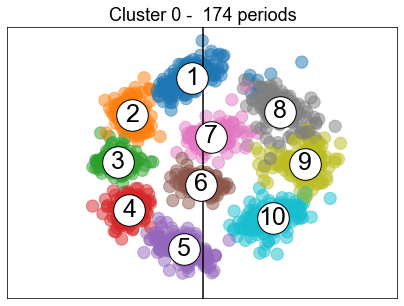

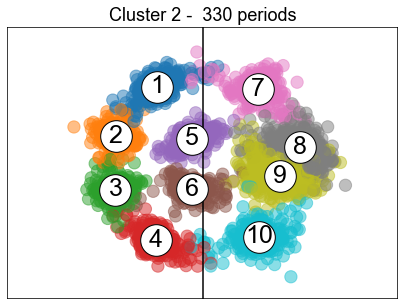

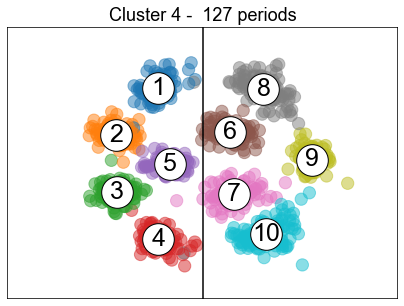

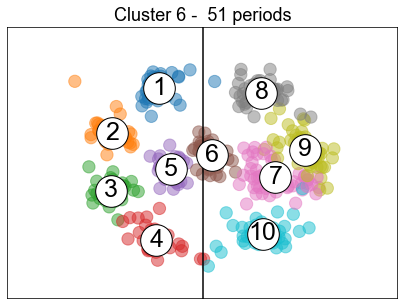

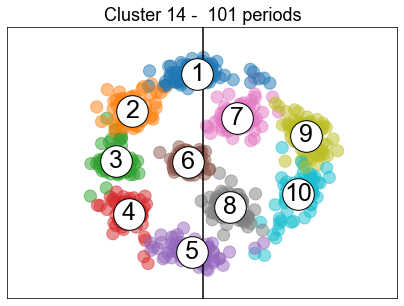

In [16]:
n_clusters = 18
dist_mat = pd.read_csv(f'data/{mode}/form_dist_mat.csv', header=None).values

model = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
model = model.fit(dist_mat)
counter = Counter(model.labels_)
outliers = []
for cluster, count in counter.items():
    if count < 15:
        outliers.append(cluster)
form_periods['cluster'] = np.where(np.isin(model.labels_, outliers), -1, model.labels_)

fm = FormManager(form_periods)
fm.visualize(group_type=LABEL_CLUSTER, ignore_outliers=True)

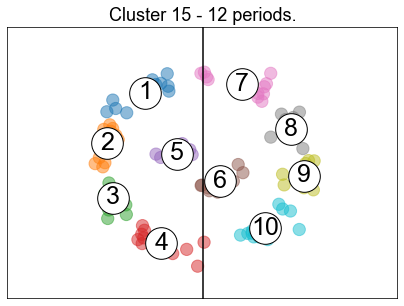

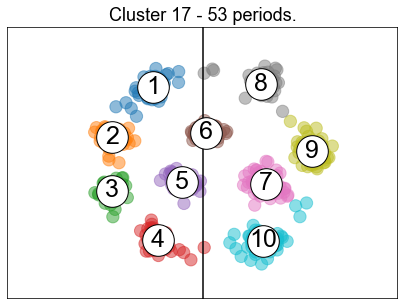

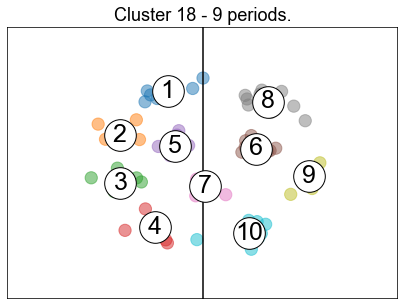

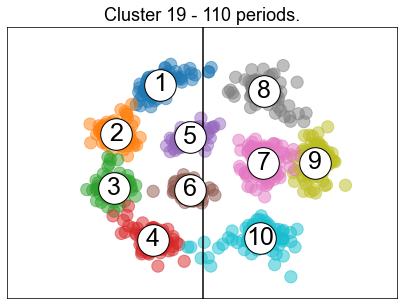

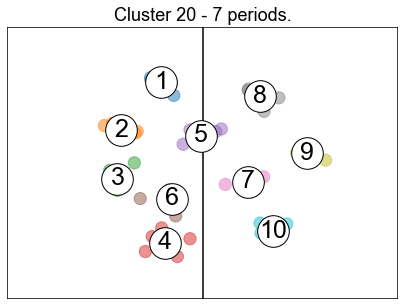

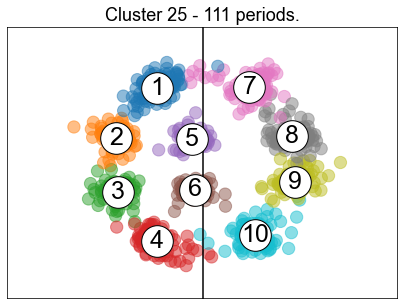

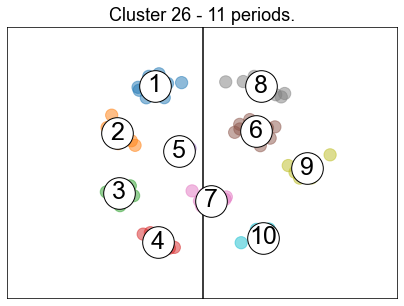

In [17]:
cluster = 2
n_clusters = 15

cluster_idxs = form_periods[form_periods['cluster'] == cluster].index
dist_mat_cluster = dist_mat[cluster_idxs][:, cluster_idxs]

submodel = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
submodel = submodel.fit(dist_mat_cluster)
counter = Counter(submodel.labels_)
outliers = []
for cluster, count in counter.items():
    if count < 5:
        outliers.append(cluster)
form_periods.loc[cluster_idxs, LABEL_CLUSTER] = np.where(
    np.isin(submodel.labels_, outliers), -1, submodel.labels_ + n_clusters
)
counts = form_periods.loc[cluster_idxs, LABEL_CLUSTER].value_counts()

clusters = [c for c in np.sort(form_periods.loc[cluster_idxs, LABEL_CLUSTER].unique()) if c != -1]
for c in clusters:
    fm.visualize_group(c, group_type=LABEL_CLUSTER)
    # plt.savefig(f'img/cluster_c{c}.pdf', bbox_inches='tight')
    plt.title(f'Cluster {c} - {counts[c]} periods.')

In [19]:
clus_to_form = {0: '343', 14: '352', 4: '433', 6: '4132', 15: '442', 25: '442',
                17: '4231', 18: '4231', 19: '4231', 20: '4231', 26: '4231', -1: 'others'}
form_periods[LABEL_FORMATION] = form_periods[LABEL_CLUSTER].apply(lambda x: clus_to_form[x])
form_periods.to_pickle(f'data/{mode}/form_periods.pkl')
form_periods

,activity_id,form_period,session,start_dt,end_dt,duration,coords,edge_mat,cluster,formation
0,12864,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820.0,"[[-706.0, 1597.0], [-1362.0, 686.0], [910.0, 1...","[[0.0, 0.981, 0.953, 0.205, 0.027, 0.814, 0.27...",25,442
1,12868,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820.0,"[[-807.0, -1612.0], [44.0, 199.0], [-373.0, -2...","[[0.0, 0.31, 0.721, 0.997, 0.207, 0.049, 0.115...",6,4132
2,12868,2,2,2020-01-01 15:02:00,2020-01-01 15:50:00,2880.0,"[[-928.0, -1915.0], [-112.0, 658.0], [-211.0, ...","[[0.0, 0.169, 0.854, 0.989, 0.126, 0.042, 0.24...",19,4231
3,12870,1,1,2020-01-01 13:30:00,2020-01-01 14:19:00,2940.0,"[[-1400.0, 57.0], [439.0, -1071.0], [-283.0, 3...","[[0.0, 0.219, 0.884, 0.097, 0.395, 0.959, 0.34...",4,433
4,12870,2,2,2020-01-01 14:33:00,2020-01-01 15:23:00,3000.0,"[[-1266.0, -146.0], [292.0, -877.0], [-205.0, ...","[[0.0, 0.393, 0.871, 0.067, 0.217, 0.998, 0.28...",-1,others
...,...,...,...,...,...,...,...,...,...,...
802,9064,2,2,2020-01-01 16:02:00,2020-01-01 16:51:00,2940.0,"[[-1424.0, 565.0], [-1553.0, -609.0], [61.0, -...","[[0.0, 0.967, 0.411, 0.062, 0.026, 0.04, 0.865...",25,442
803,9281,1,1,2020-01-01 15:00:00,2020-01-01 15:47:00,2820.0,"[[-1437.0, 113.0], [-1109.0, -959.0], [1523.0,...","[[0.0, 0.969, 0.053, 0.032, 0.028, 0.201, 0.98...",0,343
804,9281,2,2,2020-01-01 16:03:00,2020-01-01 16:51:00,2880.0,"[[-1253.0, -89.0], [-1091.0, -1035.0], [1465.0...","[[0.0, 0.934, 0.044, 0.032, 0.059, 0.194, 0.97...",0,343
805,9285,1,1,2020-01-01 14:01:00,2020-01-01 14:48:00,2820.0,"[[-638.0, 1741.0], [-1425.0, 599.0], [-1561.0,...","[[0.0, 0.986, 0.243, 0.315, 0.159, 0.738, 0.23...",6,4132


### Role Labeling

Roles aligned for formation '343'
Roles aligned for formation '352'
Roles aligned for formation '4132'
Roles aligned for formation '4231'
Roles aligned for formation '433'
Roles aligned for formation '442'
Roles aligned for formation 'others'


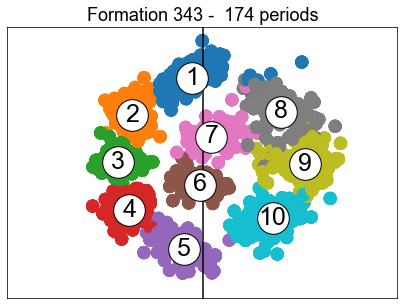

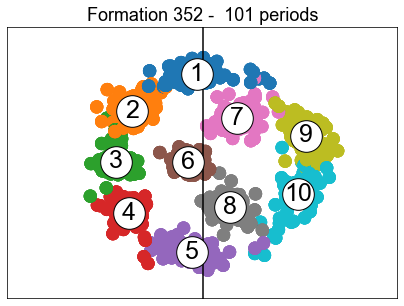

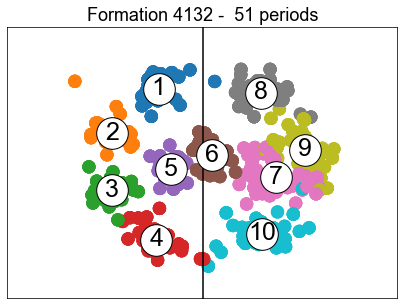

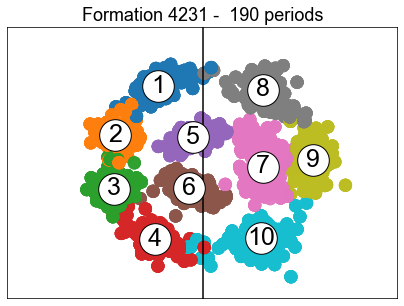

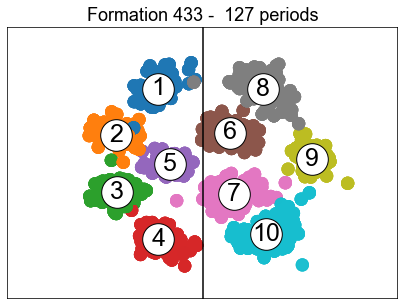

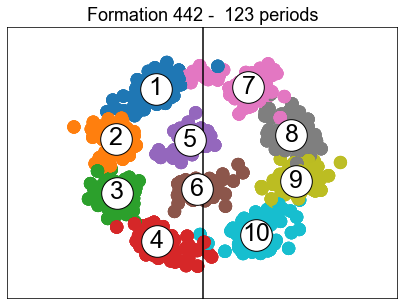

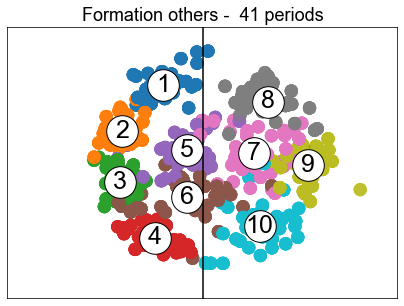

In [27]:
fm = FormManager(form_periods, role_records)
fm.align()
fm.visualize()

In [21]:
total_dur = form_periods[LABEL_DURATION].sum()
form_durs = form_periods.groupby(LABEL_FORMATION)[LABEL_DURATION].sum()

counts = form_periods[LABEL_FORMATION].value_counts()
form_props = (form_durs / total_dur).round(4)
form_mean_durs = (form_durs / form_periods[LABEL_FORMATION].value_counts()).round(1)

counts.name = 'count'
form_props.name = 'proportion'
form_mean_durs.name = 'mean_dur'

pd.concat([counts, form_props, form_mean_durs], axis=1)

,count,proportion,mean_dur
4231,190,0.2344,2870.2
343,174,0.2162,2891.3
433,127,0.1572,2880.5
442,123,0.1533,2899.5
352,101,0.1242,2860.4
4132,51,0.0635,2896.5
others,41,0.0512,2904.9


In [35]:
role_labels = pd.DataFrame([
    ['343', 'LWB', 'LCB', 'CB', 'RCB', 'RWB', 'RCM', 'LCM', 'LM', 'CF', 'RM'],
    ['352', 'LWB', 'LCB', 'CB', 'RCB', 'RWB', 'CDM', 'LCM', 'RCM', 'LCF', 'RCF'],
    ['442', 'LB', 'LCB', 'RCB', 'RB', 'LCM', 'RCM', 'LM', 'LCF', 'RCF', 'RM'],
    ['4231', 'LB', 'LCB', 'RCB', 'RB', 'LDM', 'RDM', 'CAM', 'LM', 'CF', 'RM'],
    ['433', 'LB', 'LCB', 'RCB', 'RB', 'CDM', 'LCM', 'RCM', 'LM', 'CF', 'RM'],
    ['4132', 'LB', 'LCB', 'RCB', 'RB', 'CDM', 'CAM', 'LM', 'LCF', 'RCF', 'RM'],
    ['others'] + [f'R{i}' for i in list(range(1, 11))]
], columns=[LABEL_FORMATION] + list(range(1, 11))).set_index(LABEL_FORMATION)

def give_role_labels(role_records, role_labels):
    formation = role_records[LABEL_FORMATION].iloc[0]
    role_dict = role_labels.loc[formation].to_dict()
    role_records.loc[role_records.index, LABEL_ALIGNED_ROLE] = (
        role_records.loc[role_records.index, LABEL_ALIGNED_ROLE].replace(role_dict)
    )
    return role_records

def hungarian(unit_role_records):
    cost_mat = unit_role_records[ordinary_roles].values
    _, col_idx = linear_sum_assignment(cost_mat)
    role_records.loc[unit_role_records.index, LABEL_ALIGNED_ROLE] = ordinary_roles[col_idx]
    # return unit_role_records[HEADER_ROLE_RECORDS + [LABEL_ALIGNED_ROLE]]

In [36]:
role_records = fm.role_records.groupby(LABEL_FORMATION).apply(give_role_labels, role_labels)
ordinary_role_records = role_records[role_records[LABEL_FORMATION] != 'others']
ordinary_roles = ordinary_role_records[LABEL_ALIGNED_ROLE].unique()

role_distns = ordinary_role_records.groupby(LABEL_ALIGNED_ROLE).apply(
    RoleRep.estimate_mvn, col_x=LABEL_X, col_y=LABEL_Y, filter=False
)
other_form_periods = form_periods[form_periods[LABEL_FORMATION] == 'others']
other_role_records = pd.merge(role_records, other_form_periods[[LABEL_ACTIVITY_ID, LABEL_FORM_PERIOD]])

cost_df = role_distns.apply(
    lambda n: pd.Series(-np.log(n.pdf(other_role_records[[LABEL_X, LABEL_Y]])))
).transpose()
other_role_records = pd.concat([other_role_records, cost_df], axis=1)
other_role_records.index = role_records[role_records[LABEL_FORMATION] == 'others'].index
other_role_records.groupby([LABEL_ACTIVITY_ID, LABEL_ROLE_PERIOD]).apply(hungarian)

role_records.to_csv(f'data/{mode}/role_records.csv', index=False)

### Model Evaluation

In [34]:
import seaborn as sns
sns.set(font='Arial', font_scale=1.5)

In [31]:
role_tags_true = pd.read_csv('data/role_tags_true.csv', header=0)
form_tags_true = role_tags_true[role_tags_true.columns[:-2]].drop_duplicates().reset_index(drop=True)

cols = [LABEL_ACTIVITY_ID, LABEL_FORM_PERIOD, LABEL_FORMATION]
form_tags_pred = pd.merge(role_periods, form_periods[cols])

activity_ids = form_tags_true[LABEL_ACTIVITY_ID].unique()
form_tags_pred = form_tags_pred[
    form_tags_pred[LABEL_ACTIVITY_ID].isin(activity_ids)
].reset_index(drop=True)
form_tags_pred

,activity_id,player_period,form_period,role_period,session,start_time,end_time,formation
0,2310,1,1,1,1,0,5,4132
1,2310,1,1,2,1,5,10,4132
2,2310,1,1,3,1,10,15,4132
3,2310,1,1,4,1,15,20,4132
4,2310,1,1,5,1,20,25,4132
...,...,...,...,...,...,...,...,...
586,21704,3,2,17,2,26,31,442
587,21704,3,2,18,2,31,36,442
588,21704,3,2,19,2,36,41,442
589,21704,3,2,20,2,41,46,442


In [32]:
form_header = [LABEL_ACTIVITY_ID, LABEL_SESSION, LABEL_START_TIME, LABEL_FORMATION]
role_header = form_header[:3] + [LABEL_SQUAD_NUM, LABEL_ALIGNED_ROLE]

def generate_minute_segments_inner(records, i, mode='form'):
    row = records.iloc[i]

    start_time = row[LABEL_START_TIME]
    end_time = row[LABEL_END_TIME]
    duration = end_time - start_time
    
    cols = form_header if mode == 'form' else role_header
    minute_df = pd.DataFrame(np.repeat(row[cols].values[np.newaxis], duration, axis=0), columns=cols)
    minute_df[LABEL_START_TIME] = np.arange(start_time, end_time)
    
    return minute_df

def generate_minute_segments(records, mode='form'):
    minute_df_list = Parallel(n_jobs=50)(
        delayed(generate_minute_segments_inner)(records, i, mode=mode)
        for i in tqdm(records.index)
    )
    cols = form_header if mode == 'form' else role_header
    return pd.concat(minute_df_list).sort_values(cols)

100%|██████████| 591/591 [00:00<00:00, 690.58it/s]


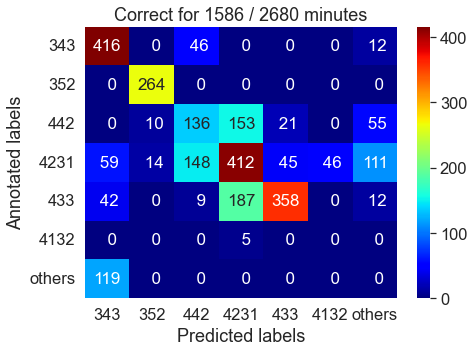

In [37]:
minute_df_true = generate_minute_segments(form_tags_true)
minute_df_pred = generate_minute_segments(form_tags_pred)

formations = ['343', '352', '442', '4231', '433', '4132', 'others']
minute_df_true[LABEL_FORMATION] = minute_df_true[LABEL_FORMATION].astype(str).apply(
    lambda x: x if x in formations[:-1] else 'others'
)

conf_mat = confusion_matrix(
    minute_df_true[LABEL_FORMATION].values,
    minute_df_pred[LABEL_FORMATION].values,
    labels=formations
)
conf_mat = pd.DataFrame(conf_mat, index=formations, columns=formations)
minute_df_common = pd.merge(minute_df_true, minute_df_pred)

plt.figure(figsize=(7, 5))
sns.set(font_scale=1.5)
sns.heatmap(conf_mat, cmap='jet', annot=True, fmt='3d', annot_kws={"size": 17,})
plt.title(f"Correct for {len(minute_df_common)} / {len(minute_df_true)} minutes")
plt.xlabel("Predicted labels")
plt.ylabel("Annotated labels")
plt.savefig('img/{mode}_form_conf.pdf', bbox_inches='tight')

100%|██████████| 1718/1718 [00:03<00:00, 525.65it/s]


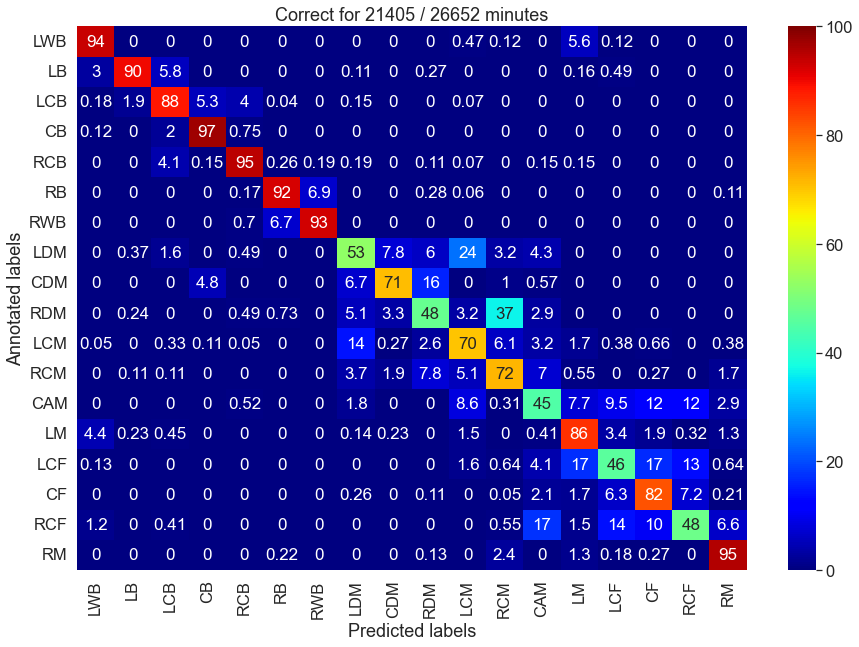

In [40]:
right_cols = (
    HEADER_ROLE_RECORDS[:5] +
    [LABEL_FORMATION, LABEL_PLAYER_ID, LABEL_SQUAD_NUM, LABEL_ALIGNED_ROLE]
)
role_tags_pred = pd.merge(role_periods, role_records[right_cols])

activity_ids = role_tags_true[LABEL_ACTIVITY_ID].unique()
records = role_tags_pred[role_tags_pred[LABEL_ACTIVITY_ID].isin(activity_ids)].reset_index(drop=True)
minute_df_pred = generate_minute_segments(records, mode='role')

minute_df_true = generate_minute_segments(role_tags_true, mode='role')
minute_df_true = pd.merge(minute_df_pred[role_header[:-1]], minute_df_true)

roles = [
    'LWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'RWB',
    'LDM', 'CDM', 'RDM', 'LCM', 'RCM', 'CAM',
    'LM', 'LCF', 'CF', 'RCF', 'RM'
]
conf_mat = confusion_matrix(
    minute_df_true[LABEL_ALIGNED_ROLE].values,
    minute_df_pred[LABEL_ALIGNED_ROLE].values,
    labels=roles
)
conf_mat = confusion_matrix(
    minute_df_true[LABEL_ALIGNED_ROLE].values,
    minute_df_pred[LABEL_ALIGNED_ROLE].values,
    labels=roles, normalize='true'
)
conf_mat = pd.DataFrame(conf_mat, index=roles, columns=roles).round(4) * 100
minute_df_common = pd.merge(minute_df_true, minute_df_pred)

plt.figure(figsize=(15, 10))
sns.set(font_scale=1.5)
sns.heatmap(conf_mat, vmin=0, vmax=100, cmap='jet', annot=True, annot_kws={"size": 17,})
plt.title(f"Correct for {len(minute_df_common)} / {len(minute_df_true)} minutes")
plt.xlabel("Predicted labels")
plt.ylabel("Annotated labels")
plt.savefig(f'img/{mode}_role_conf.pdf', bbox_inches='tight')